In [51]:
# Important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scikitplot as skplt

%matplotlib inline

In [52]:
#sklearn imports
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.svm.libsvm import predict_proba
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression



In [53]:
#File reading function
def read_files(): 
    df_train = pd.read_csv('../data/9db113a1-cdbe-4b1c-98c2-11590f124dd8.csv')
    df_test_nolabel = pd.read_csv('../data/testset.csv')
    return(df_train, df_test_nolabel)

In [54]:
#Grab files
df_train, df_test_nolabel = read_files()


In [55]:
#Info
df_train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [56]:
df_train.shape

(576, 6)

C:\Users\youri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\youri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


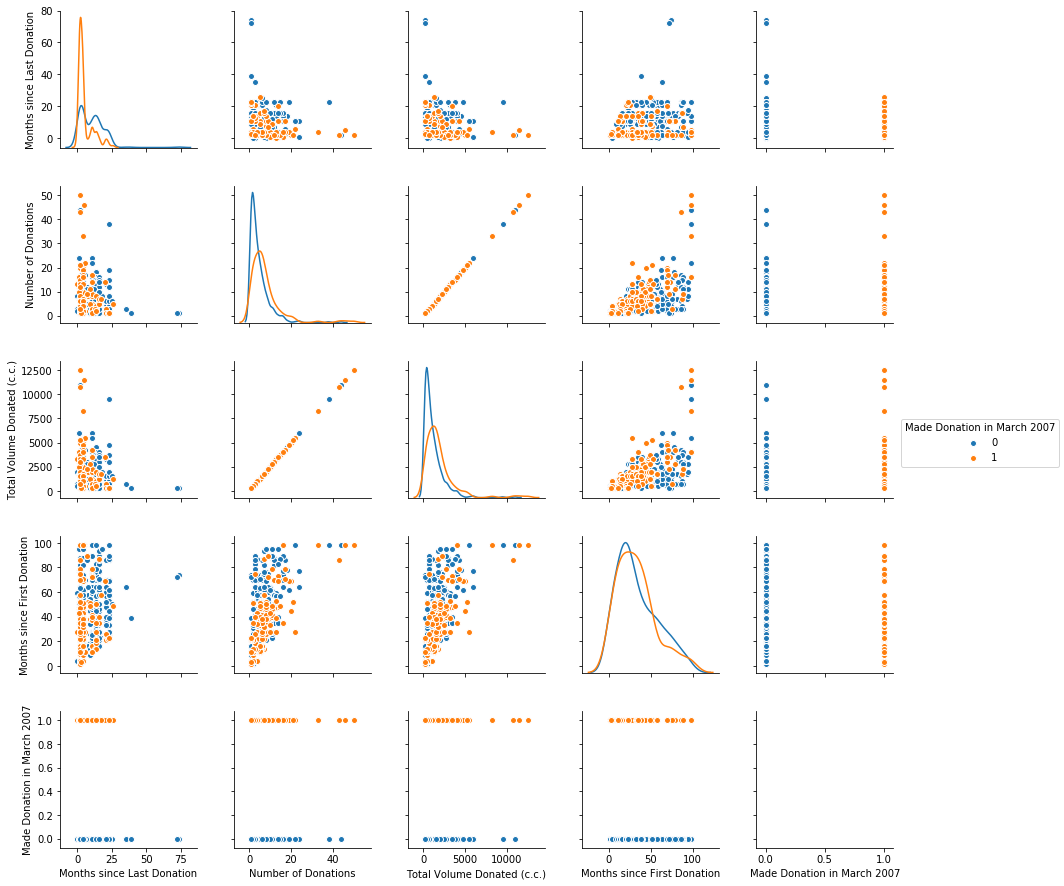

In [57]:
#Quick overview of relation between / seperation of classes
sns.pairplot(df_train.iloc[:,1:], diag_kind='kde', hue='Made Donation in March 2007')

In [58]:
#Don't select all features
X = df_train.iloc[:,[1, 2, 4]]
y = df_train.iloc[:,-1]

In [59]:
#Grid Search parameters
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 200, 300]}

In [60]:
##Train/test pretty much according to size used in grid_search below
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [61]:
#Init model
logreg = LogisticRegression()

In [62]:
#Grid search
grid_search = GridSearchCV(logreg, param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [63]:
#Run prediction
grid_search_y_predict = grid_search.predict(X_test)

In [64]:
print("Grid search best params: {}".format(grid_search.best_params_))
print("Grid search best score on training set: {}".format(grid_search.best_score_))
print("Score on the test set with these params: {}".format(grid_search.score(X_test, y_test)))

Grid search best params: {'C': 0.01}
Grid search best score on training set: 0.7688311688311689
Score on the test set with these params: 0.7539267015706806


In [65]:
#What do the test set values look like?
y_test.value_counts()

0    142
1     49
Name: Made Donation in March 2007, dtype: int64

C:\Users\youri\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


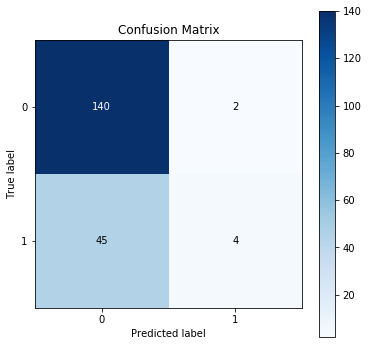

In [66]:
##Confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
skplt.metrics.plot_confusion_matrix(y_test, grid_search_y_predict, ax=ax)

In [67]:
#Cohen kappa
print("Cohen kappa score: {}".format(cohen_kappa_score(y_test, grid_search_y_predict)))

Cohen kappa score: 0.09478672985781988


In [68]:
#Classification report - looks very subpar on the 1-side of things.
print(classification_report(y_test, grid_search_y_predict))

             precision    recall  f1-score   support

          0       0.76      0.99      0.86       142
          1       0.67      0.08      0.15        49

avg / total       0.73      0.75      0.67       191



In [69]:
#Get the probabilities, we need them later
grid_search_pred_proba = grid_search.predict_proba(X_test)

In [70]:
#Grid search results
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.001661,9.405491e-04,0.000333,0.000470,0.01,{'C': 0.01},0.759690,0.767442,0.779528,0.768831,0.008148,1,0.812500,0.78125,0.755814,0.783188,0.023183
1,0.001995,8.154660e-04,0.000332,0.000470,0.1,{'C': 0.1},0.728682,0.775194,0.787402,0.763636,0.025307,7,0.804688,0.78125,0.755814,0.780584,0.019958
2,0.000997,3.371748e-07,0.000000,0.000000,1,{'C': 1},0.728682,0.782946,0.787402,0.766234,0.026718,2,0.800781,0.78125,0.759690,0.780574,0.016782
3,0.000997,1.173403e-06,0.000999,0.000003,10,{'C': 10},0.728682,0.782946,0.787402,0.766234,0.026718,2,0.800781,0.78125,0.759690,0.780574,0.016782
4,0.001997,3.146965e-06,0.000000,0.000000,100,{'C': 100},0.728682,0.782946,0.787402,0.766234,0.026718,2,0.800781,0.78125,0.759690,0.780574,0.016782


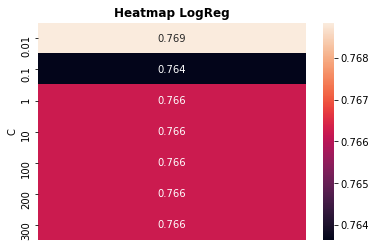

In [73]:
#Heatmap (or, well, heat-bar?!)
scores = np.array(results.mean_test_score).reshape(7,1)
ax = sns.heatmap(scores, xticklabels='', yticklabels=param_grid['C'], fmt='.3g', annot=True)
ax.set(xlabel='', ylabel='C')
ax.set_title("Heatmap LogReg", fontweight='bold')
plt.savefig("../img/heatmapLOGREG.png")

In [74]:
#Calculate log loss on test data
log_loss(y_test, grid_search_pred_proba)

0.4952808464066558

### N.B.: Code below is solely to prepare results for DrivenData submission format
I've left this code snippet included in order to show the *entire* challenge. However, this code will no longer work, as I have intentionally left out the required submission CSV.

In [114]:
final_proba = grid_search.predict_proba(df_test_nolabel.iloc[:,[1,2,4]])

export_probas = pd.read_csv('../data/BloodDonationSubmissionFormat.csv', index_col=0)

export_probas['Made Donation in March 2007'] = [x[1] for x in final_proba]

export_probas.head()

export_probas.to_csv('../data/subm_svc_2.csv')